### **Práctica: Autoencoder para Eliminar Ruido en Imágenes**  
### **Configuración Inicial** 
1. Instalar bibliotecas necesarias (ej: TensorFlow/Keras, NumPy, Matplotlib).  
2. Cargar el dataset CIFAR-10 usando la API de Keras.  
3. Explorar las imágenes:  
   - Visualizar 10 ejemplos aleatorios.  
   - Verificar dimensiones de las imágenes (ej: 32x32 píxeles, 3 canales RGB).

In [1]:
from tensorflow.keras.datasets import cifar10

# Load the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Print the shapes to verify the data loading
print("Training data shape:", x_train.shape)
print("Training labels shape:", y_train.shape)
print("Test data shape:", x_test.shape)
print("Test labels shape:", y_test.shape)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step
Training data shape: (50000, 32, 32, 3)
Training labels shape: (50000, 1)
Test data shape: (10000, 32, 32, 3)
Test labels shape: (10000, 1)


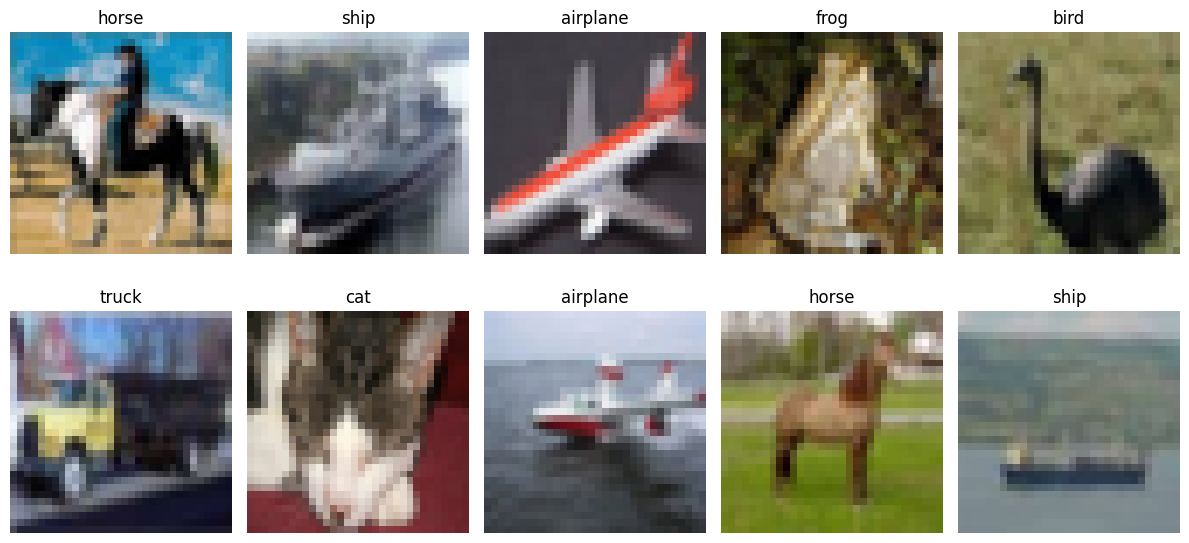

In [2]:
import numpy as np

import matplotlib.pyplot as plt

# CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

# Create a figure with 2x5 subplots
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.flatten()

# Select 10 random images from the training set
indices = np.random.randint(0, x_train.shape[0], 10)

for i, idx in enumerate(indices):
    # Display the image
    axes[i].imshow(x_train[idx])
    axes[i].set_title(class_names[y_train[idx][0]])
    axes[i].axis('off')  # Hide axes

plt.tight_layout()
plt.show()

### **Preparación de Datos**
1. Normalizar los valores de píxeles al rango [0, 1].  
2. Crear un dataset "ruidoso":  
   - Añadir ruido Gaussiano (media=0, desviación estándar=0.1) a las imágenes originales.  
   - Asegurar que los valores de píxeles estén en [0, 1] después de añadir ruido.   `np.clip(imagen_con_ruido, 0., 1.)`
3. Dividir los datos en entrenamiento (50,000 imágenes) y prueba (10,000 imágenes).  
Ya viene pre-dividido por defecto en keras.datasets.cifar10.load_data().

Normalized training data shape: (50000, 32, 32, 3)
Noisy training data shape: (50000, 32, 32, 3)
Original value range: [0.0000, 1.0000]
Noisy value range: [0.0000, 1.0000]


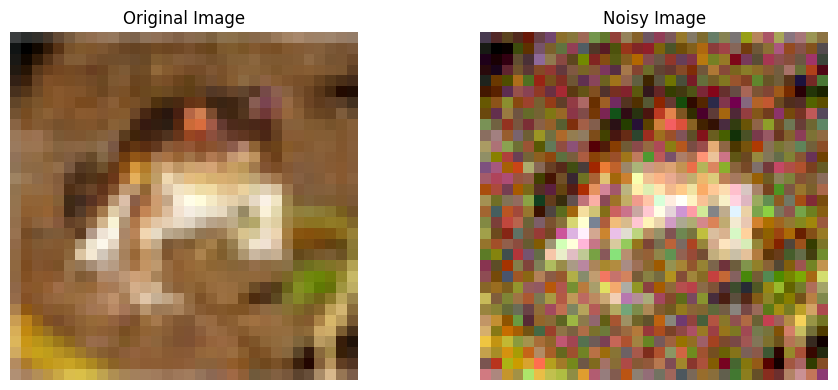

In [3]:
# 1. Normalize pixel values to [0, 1]
x_train_normalized = x_train.astype('float32') / 255.0
x_test_normalized = x_test.astype('float32') / 255.0

# 2. Create noisy versions of the data
# Set random seed for reproducibility
np.random.seed(42)

# Add Gaussian noise with mean=0 and std=0.1
noise_factor = 0.1
x_train_noisy = x_train_normalized + np.random.normal(loc=0.0, scale=noise_factor, size=x_train_normalized.shape)
x_test_noisy = x_test_normalized + np.random.normal(loc=0.0, scale=noise_factor, size=x_test_normalized.shape)

# 3. Clip the values to ensure they stay in [0, 1]
x_train_noisy = np.clip(x_train_noisy, 0.0, 1.0)
x_test_noisy = np.clip(x_test_noisy, 0.0, 1.0)

# Print shapes and value ranges to verify
print("Normalized training data shape:", x_train_normalized.shape)
print("Noisy training data shape:", x_train_noisy.shape)
print(f"Original value range: [{x_train_normalized.min():.4f}, {x_train_normalized.max():.4f}]")
print(f"Noisy value range: [{x_train_noisy.min():.4f}, {x_train_noisy.max():.4f}]")

# Display a sample original and noisy image
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(x_train_normalized[0])
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(x_train_noisy[0])
plt.title('Noisy Image')
plt.axis('off')

plt.tight_layout()
plt.show()

### **Diseño de la Arquitectura** 
1. **Encoder**:  
   - Capas convolucionales (`Conv2D`) con activación ReLU.  
   - Reducir progresivamente las dimensiones espaciales (ej: 32x32 → 16x16 → 8x8).  
   - Capa final: "cuello de botella" (espacio latente).  
2. **Decoder**:  
   - Capas transpuestas (`Conv2DTranspose`) para reconstruir la imagen.  
   - Usar activación **sigmoid** en la última capa (rango [0, 1]).  

In [4]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam

# Input shape
input_shape = (32, 32, 3)

# Encoder
inputs = Input(shape=input_shape)

# Encoder - First convolutional block
x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
x = MaxPooling2D((2, 2), padding='same')(x)  # 32x32 -> 16x16

# Encoder - Second convolutional block
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)  # 16x16 -> 8x8

# Encoder - Third convolutional block (bottleneck)
encoded = Conv2D(128, (3, 3), activation='relu', padding='same')(x)  # 8x8 bottleneck

# Decoder - First deconvolutional block
x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)  # 8x8 -> 16x16

# Decoder - Second deconvolutional block
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)  # 16x16 -> 32x32

# Decoder - Output layer
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

# Create the autoencoder model
autoencoder = Model(inputs, decoded)

# Compile the model
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Print model summary
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 3)      │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 186,371 (728.01 KB)

 Trainable params: 186,371 (728.01 KB)

 Non-trainable params: 0 (0.00 B)

### **Entrenamiento del Modelo**  
1. Compilar el modelo:  
   - Función de pérdida: **MSE** (Error Cuadrático Medio).  
   - Optimizador: **Adam** con learning rate=0.001.  
2. Entrenar con datos ruidosos como entrada y datos originales como target.  
   - Batch size: 64-128.  
   - Épocas: 20-30 (monitorear la pérdida para evitar overfitting).  (puedes utilizar EarlyStopping con paciencia de 3-5 épocas, para evitar entrenar de más innecesariamente.)
3. Guardar el modelo entrenado para evaluación.  

Epoch 1/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 22s 62ms/step - loss: 0.0075 - val_loss: 0.0057
Epoch 2/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 26s 74ms/step - loss: 0.0056 - val_loss: 0.0050
Epoch 3/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 29s 82ms/step - loss: 0.0050 - val_loss: 0.0051
Epoch 4/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 28s 79ms/step - loss: 0.0047 - val_loss: 0.0044
Epoch 5/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 24s 69ms/step - loss: 0.0044 - val_loss: 0.0042
Epoch 6/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 25s 71ms/step - loss: 0.0043 - val_loss: 0.0040
Epoch 7/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 26s 72ms/step - loss: 0.0041 - val_loss: 0.0042
Epoch 8/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 24s 68ms/step - loss: 0.0039 - val_loss: 0.0038
Epoch 9/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 25s 70ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 10/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 24s 69ms/step - loss: 0.0036 - val_loss: 0.0034
Epoch 11/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 25s 70ms/step - loss: 0.0035 - val_loss: 0.0034
Epoch 12/25
352/352 ━━━━━━━━━━

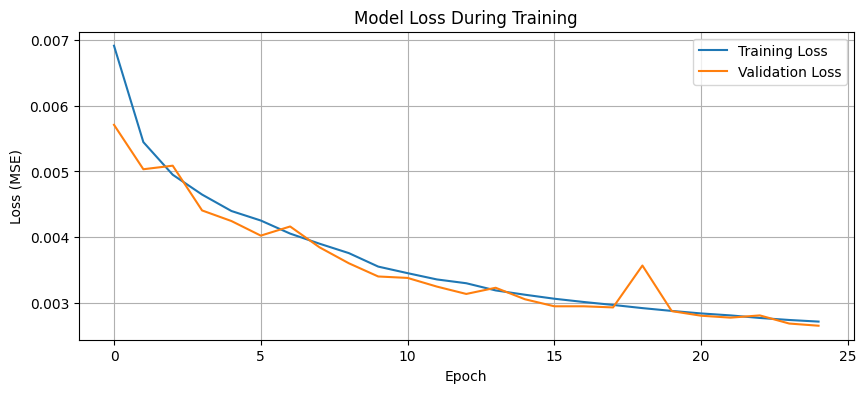

Training completed!


In [6]:
from tensorflow.keras.callbacks import EarlyStopping

# Define training parameters
batch_size = 128
epochs = 25  # Increased from 10 to 25 (within the 20-30 range)
validation_split = 0.1

# Import necessary modules for early stopping

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=4,  # 3-5 epochs of patience
    restore_best_weights=True,
    verbose=1
)

# Train the model
history = autoencoder.fit(
    x_train_noisy,          # Input: noisy images
    x_train_normalized,     # Target: clean images
    batch_size=batch_size,
    epochs=epochs,
    validation_split=validation_split,
    shuffle=True,
    verbose=1,
    callbacks=[early_stopping]  # Added early stopping
)

# Plot training & validation loss
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

# Save the model
autoencoder.save('cifar10_denoising_autoencoder.h5')

print("Training completed!")

### **Evaluación y Visualización**  
1. **Cuantitativa**: Calcular el **PSNR** (Peak Signal-to-Noise Ratio) entre imágenes originales y reconstruidas.  
   - Valores altos de PSNR indican mejor calidad.  
2. **Cualitativa**: Visualizar ejemplos de:  
   - Imagen original.  
   - Imagen ruidosa (input).  
   - Imagen reconstruida (output).  

Generating reconstructions...
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Calculating PSNR...
Average PSNR on test set: 26.06 dB
Visualizing examples...


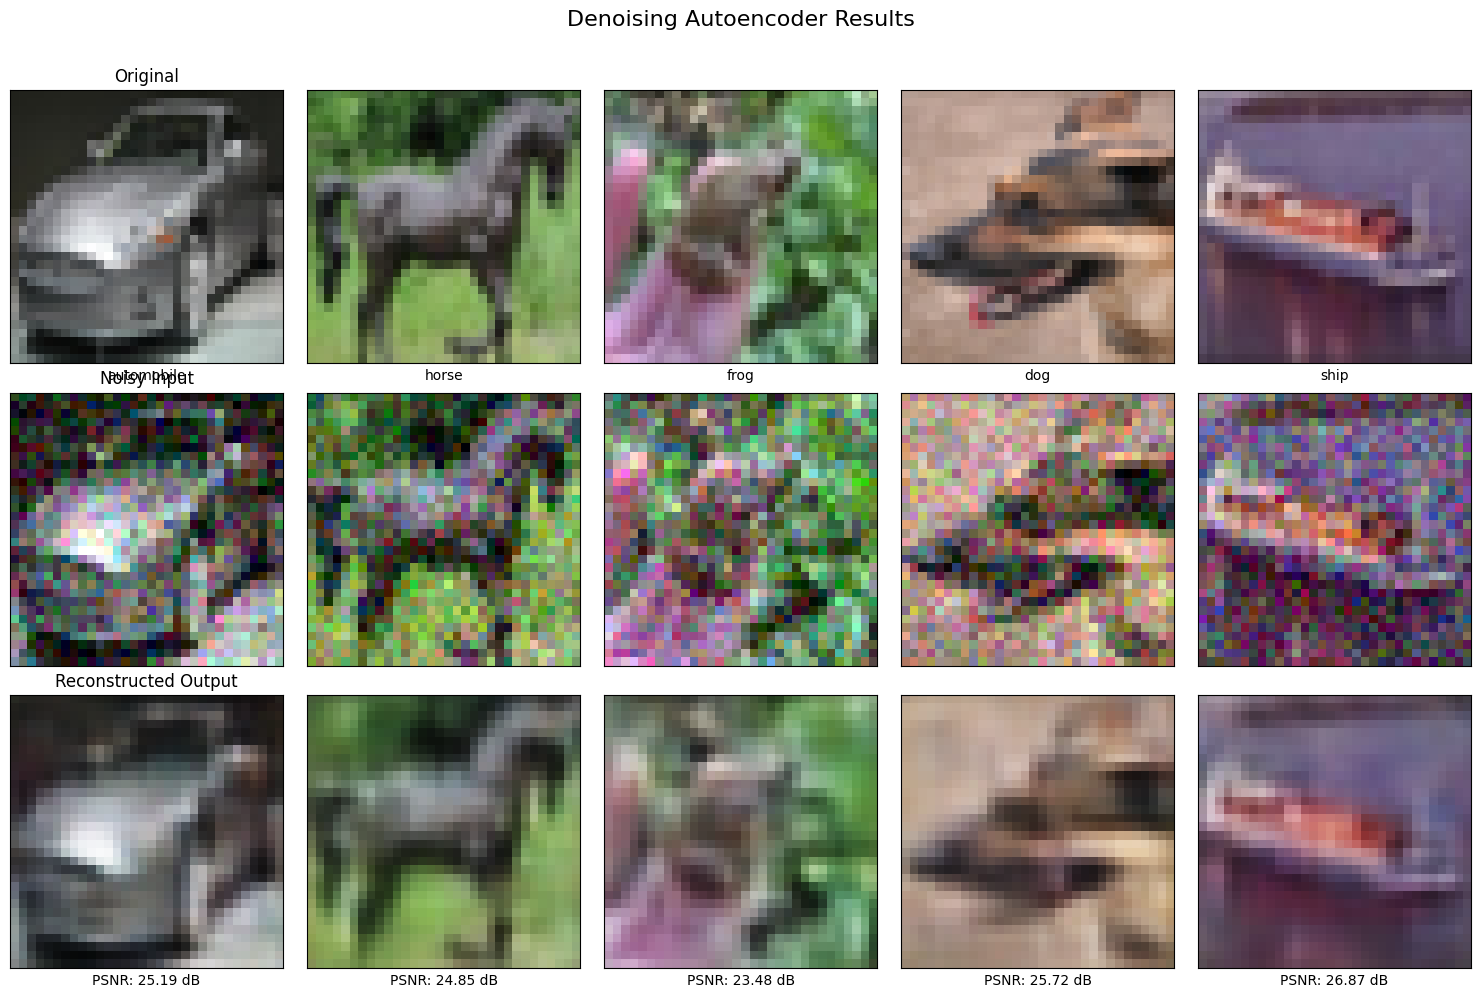

In [7]:
# Calculate PSNR between original and reconstructed images
def calculate_psnr(original, reconstructed):
    mse = np.mean((original - reconstructed) ** 2)
    psnr = 10 * np.log10(1.0 / (mse + 1e-8))
    return psnr

# Generate reconstructions for test data
print("Generating reconstructions...")
x_test_reconstructed = autoencoder.predict(x_test_noisy)

# Calculate PSNR on the test data
print("Calculating PSNR...")
test_psnr_values = []
for i in range(len(x_test_normalized)):
    psnr = calculate_psnr(x_test_normalized[i], x_test_reconstructed[i])
    test_psnr_values.append(psnr)

avg_test_psnr = np.mean(test_psnr_values)
print(f"Average PSNR on test set: {avg_test_psnr:.2f} dB")

# Visualize examples
print("Visualizing examples...")
n_examples = 5
example_indices = np.random.randint(0, len(x_test_normalized), n_examples)

# Create a figure with 3 rows (original, noisy, reconstructed) and n_examples columns
plt.figure(figsize=(15, 10))
for i, idx in enumerate(example_indices):
    # Get the class name for this example
    class_name = class_names[y_test[idx][0]]
    
    # Calculate PSNR for this specific example
    example_psnr = calculate_psnr(x_test_normalized[idx], x_test_reconstructed[idx])
    
    # Original image
    plt.subplot(3, n_examples, i + 1)
    plt.imshow(x_test_normalized[idx])
    if i == 0:
        plt.title("Original")
    plt.xlabel(f"{class_name}")
    plt.xticks([])
    plt.yticks([])
    
    # Noisy image
    plt.subplot(3, n_examples, i + 1 + n_examples)
    plt.imshow(x_test_noisy[idx])
    if i == 0:
        plt.title("Noisy Input")
    plt.xticks([])
    plt.yticks([])
    
    # Reconstructed image
    plt.subplot(3, n_examples, i + 1 + 2*n_examples)
    plt.imshow(x_test_reconstructed[idx])
    if i == 0:
        plt.title("Reconstructed Output")
    plt.xlabel(f"PSNR: {example_psnr:.2f} dB")
    plt.xticks([])
    plt.yticks([])

plt.suptitle("Denoising Autoencoder Results", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()